Data obtaining
---
---

In [ ]:
pip install tqdm

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
from multiprocessing import Pool
import tqdm
from datetime import date

Scraping one page

In [ ]:
def parse_one_page(i):
    arr = []
    url_search_page = 'https://re.actor/rossiya?sort=rating%2Cdesc%2Cplaced%2Cdesc&page='
    soup_search_page = BeautifulSoup(requests.get(url_search_page + str(i)).text, 'lxml')
    items = soup_search_page.find('div', {'class': 'mp-main-page__order-items'})
    item = items.find_next('div', {'class': 'mp-main-page__order-item'})
    while item:
        arr.append([np.nan] * 8)

        try:
            # Status
            arr[-1][0] = item.find('div', {'class': 'mp-order-label mp-order-item__label'}).get_text()
        except Exception:
            pass
        
        # Publish date
        arr[-1][1] = item.find('div', {'class': 'mp-order-item__date'}).get_text()

        # Title
        arr[-1][2] = item.find('div', {'class': 'mp-order-item__title'}).get_text()

        # Price
        s = item.find('div', {'class': 'mp-order-item__meta'}).find('div', {'class': 'mp-order-item__price'}).get_text().split(' ')
        if s[0] == 'Бесплатно':
            arr[-1][3] = 0
            arr[-1][4] = '₽'
        else:
            arr[-1][3] = float(s[0])
            arr[-1][4] = s[1]

        # Amount
        s = item.find('div', {'class': 'mp-order-item__meta'}).find('div', {'class': 'mp-order-item__amount'}).get_text().strip().split()
        arr[-1][5] = float(s[0])
        arr[-1][6] = s[1]

        # Type
        arr[-1][7] = item.find('div', {'class': 'mp-order-item__tag'}).find('span').get_text()             

        try:
            item = item.find_next('div', {'class': 'mp-main-page__order-item'})
        except Exception:
            item = False        
    return arr

Main parser with multiprocessing

In [ ]:
def parse_search(url_search, max_search_pages):
    pages = [i for i in range(0, max_search_pages)]
    pool = Pool(20)

    buff = []
    for result in tqdm.tqdm(pool.imap_unordered(parse_one_page, pages), total=len(pages)):
        buff.append(result)
    print()
    
    pool.close()
    pool.join()
    
    print('Web Scraping is completed')
    return buff

Web Scraping process

In [ ]:
url_search = 'https://re.actor/rossiya?sort=rating%2Cdesc%2Cplaced%2Cdesc&page='
r_search = requests.get(url_search + '0')
soup_search = BeautifulSoup(r_search.text, 'lxml')
s = soup_search.find('script').get_text()
s = re.findall(r'totalPages":\d+', s)
max_search_pages = int(str(s[0]).replace('totalPages":', ''))
wastes_reactor_raw = parse_search(url_search, int(max_search_pages))

100%|██████████| 539/539 [00:38<00:00, 14.15it/s]



Web Scraping is completed


Processing obtained data

In [ ]:
flat_list = [item for sublist in wastes_reactor_raw for item in sublist]
wastes_reactor_list = np.array(flat_list)
columns = ['Status',
           'Date',
           'Title',
           'Price',
           'Price_units',
           'Amount',
           'Amount_units',
           'Waste_type']
wastes_reactor = pd.DataFrame(wastes_reactor_list, columns=columns)
wastes_reactor['Status'] = wastes_reactor['Status'].replace('nan', 'Открыто')
months = {'января': '01',
          'февраля': '02',
          'марта': '03',
          'апреля': '04',
          'мая': '05',
          'июня': '06',
          'июля': '07',
          'августа': '08',
          'сентября': '09',
          'октября': '10',
          'ноября': '11',
          'декабря': '12'}
for m in months:
    wastes_reactor['Date'] = wastes_reactor['Date'].apply(lambda x: x.replace(m, months[m]))
wastes_reactor['Date'] = pd.to_datetime(wastes_reactor['Date'], format='%d %m %Y')
wastes_reactor

,Status,Date,Title,Price,Price_units,Amount,Amount_units,Waste_type
0,Открыто,2021-10-22,Реализуем Пеногаситель Kurita FC-8990,350000.0,₽/т.,3.0,т.,Остальное
1,Открыто,2021-10-22,Реализуем Масло-растворитель Изолюкс-1М ТУ 19....,50000.0,₽/т.,2.0,т.,Остальное
2,Открыто,2021-10-22,Реализуем металлолом,25000.0,₽/т.,40.0,т.,Металлы
3,Открыто,2021-10-22,Лом стальной (тара из черных металлов),10065.6,₽/т.,100.0,т.,Металлы
4,Открыто,2021-10-22,Продаём тонкий картон 6Б типографский,17000.0,₽/т.,20.0,т.,Макулатура
...,...,...,...,...,...,...,...,...
10773,Открыто,2019-04-22,Утилизация ламп дневного света (люминесцентные...,17.0,₽/шт.,500.0,шт.,Электроника
10774,Открыто,2019-04-22,Принимаем б/у пластиковые корзинки,15.0,₽/кг.,30000.0,кг.,Пластик
10775,Открыто,2019-04-22,Закупаем ПНД канистру и бочки прессованные и н...,35.0,₽/кг.,1000.0,кг.,Пластик
10776,Открыто,2019-04-22,Закупаем отходы ПНД и ПВД,30.0,₽/кг.,10000.0,кг.,Пластик


Save to csv and excel

In [ ]:
today = date.today()
d1 = today.strftime("%Y_%m_%d")
wastes_reactor.to_csv('wastes_reactor_' + d1 + '.csv', index=False, encoding='utf-8-sig')
wastes_reactor.to_excel('wastes_reactor_' + d1 + '.xlsx', index=False, encoding='utf-8-sig')

Estimation of industrial waste products market in Russia
---
---

The estimation was carried out using Tableau Public 2021 within the framework of the project "Экологически-рациональная альтернатива" (Environmentally sustainable alternative). The project is a web marketplace for the sale of industrial waste products with integration of state personal account of a natural resource user. The project aims to simplify the sale of waste products from manufacturers, the resources search for waste disposers and the interaction of both sides with government authorities. It is assumed that the project will increase the number of recycled waste and reduce the number of landfills as part of the implementation of the national project Ecology.

---
**Market estimation from the top**

The global waste management market is $1.6T in 2020 [(Link_1)](https://www.alliedmarketresearch.com/waste-management-market).

The global disposal waste market is $54B (3,3 %) [(Link_2)](https://www.marketresearch.com/MarketLine-v3883/Waste-Management-Russia-13513245/).

• **PAM** – The waste management market in Russia is $5.4B ≈ 380 billion rub. in 2020 [(Link_3)](https://documents1.worldbank.org/curated/pt/702251549554831489/pdf/Waste-in-Russia-Garbage-or-Valuable-Resource.pdf).

• **TAM** – To disposal (7 %) = 26.6 billion rub. 

• **SAM** – To sale (2 %) = 532 million rub. 


---
**Bottoom-up market estimation**

The market estimation was performed with bottom-up assessment (TAM, SAM) based on the data from the site [Реактор](https://re.actor/rossiya). It's one of three biggest waste marketplaces in Russia. Two others are [Vtorpoisk](https://vtorpoisk.ru/) and [ВторПлюс](https://vtorplus.com/).

Estimated market shares of TAM:
   * Реактор – 3 %
   * Vtorpoisk – 1 %
   * ВторПлюс – 0.2 %
   * Others = 0.01 %

Market shares of SAM are 71:24:4:1 (Реактор, ВторПлюс, Vtorpoisk, Others).
It's accepted 4360 sale announcements for TAM in 2020. 

The amount of open announcements per year:
   * Реактор – 4229 (2020)
   * Vtorpoisk – 1390 (2021)
   * ВторПлюс – 252 (2020)

The market estimations are followings:

*   TAM - 41 billion rub (2020)
*   SAM - 660 million rub (468 million rub for Реактор; median trade is 3.9 million rub; 120 trades per year)

---
**SOM**

Ratio of shares of competitors on the russian market is 71 : 24 : 4 : 1 (Реактор, Vtorpoisk, ВторПлюс, Others).

Potential market share = 25 % 

With an average SAM = 600 million rub. SOM 25 % = 150 million rub. 

With an average commission 2 % estimated profit is 3.0 million tub. per year

---
Link to the Tableau dashboard with the analysis tables: https://public.tableau.com/views/_16350699888960/sheet6?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

In [ ]:
%%HTML
<div class='tableauPlaceholder' id='viz1635081811712' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;_1&#47;_16350699888960&#47;sheet6&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='_16350699888960&#47;sheet6' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;_1&#47;_16350699888960&#47;sheet6&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1635081811712');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

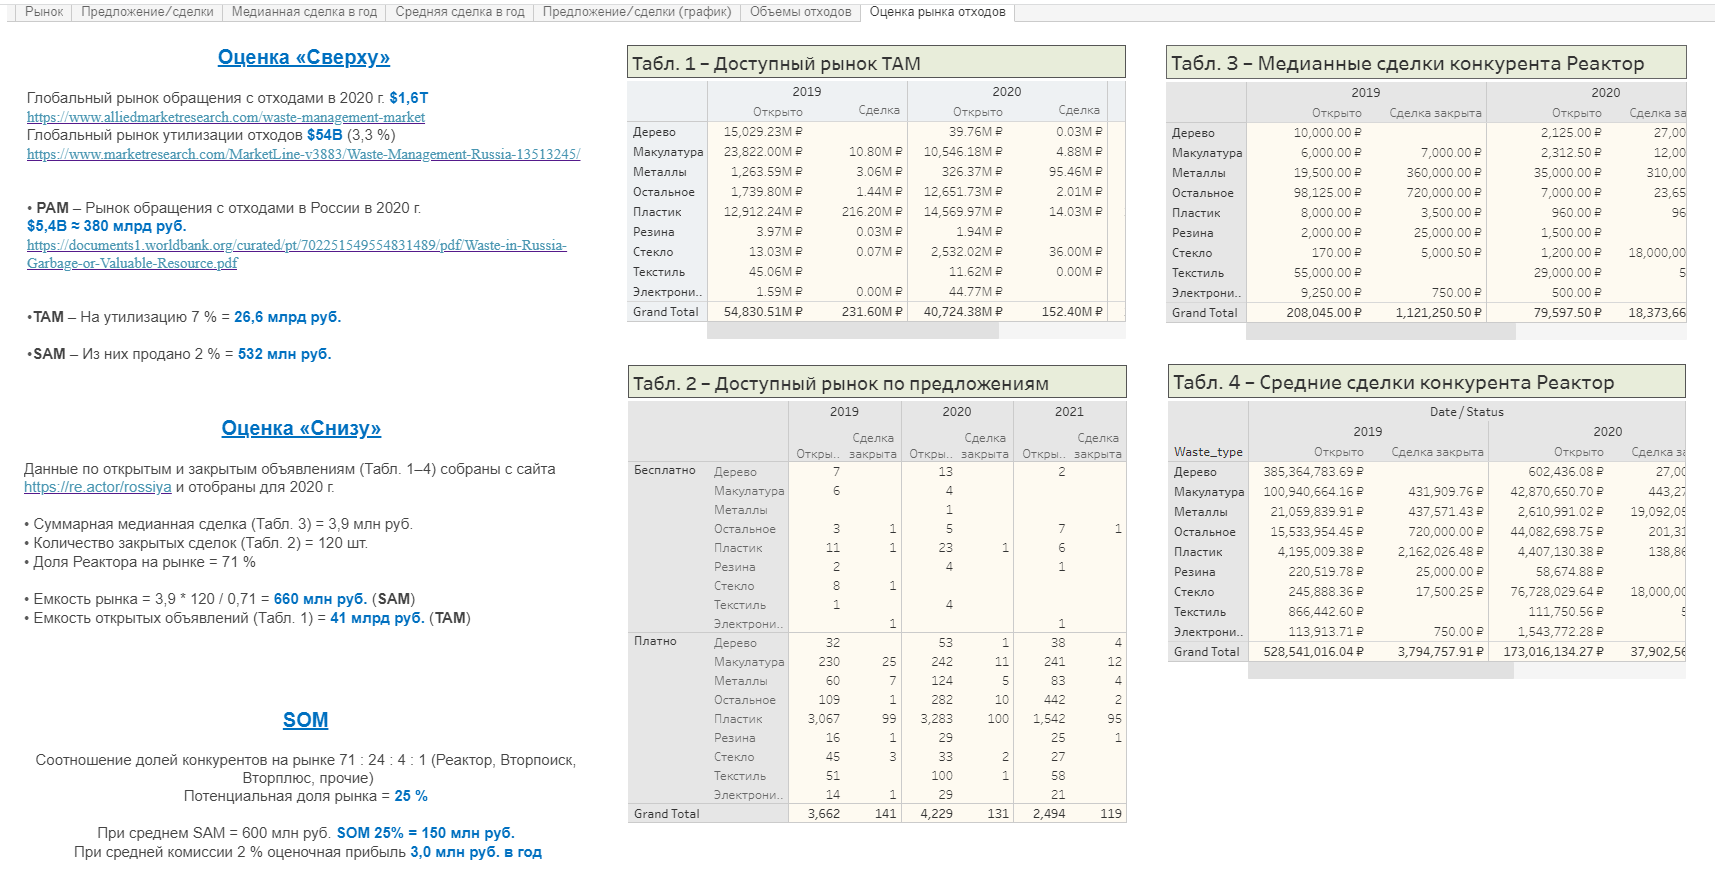